In [1]:
import csv
# Libs
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.models import resnet18
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np

In [2]:
csv_file_path = 'Data_Entry_2017_v2020.csv'
data = {}
with open(csv_file_path,mode='r',newline='') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    headers = csv_reader.fieldnames
    for row in csv_reader:
            data[row['Image Index']] = float(row['Patient Age'])

print(data['00022065_032.png'])

47.0


In [3]:
class MyImageFolder(datasets.ImageFolder):  
    def __init__(self, root, transform=None, target_transform=None,  
                 loader=datasets.folder.default_loader,  
                 is_valid_file=None,age_map=None):  
        super(MyImageFolder, self).__init__(root, transform, target_transform, loader, is_valid_file)  
        self.age_map = age_map

    def __getitem__(self, index): 
        path, _ = self.samples[index] 
        age = torch.tensor(self.age_map[path[-16:]],dtype=torch.float)
        sample, target = super(MyImageFolder, self).__getitem__(index) 
        return sample, target, age

In [4]:
# Load data
torch.manual_seed(42)
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
train_transform_gpu = transforms.Compose([
    transforms.RandomCrop(224,32),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform_gpu = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])
train_ds = MyImageFolder('./task_images_downsampled/train',
                                transform = train_transform,age_map=data)
test_ds = MyImageFolder('./task_images_downsampled/test',
                                transform = test_transform,age_map=data)
batch_size=64
def get_dataloader_workers():
    return 4
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=get_dataloader_workers())
test_dl = DataLoader(test_ds,batch_size=batch_size,num_workers=get_dataloader_workers())

tensor(73.)
tensor(0)


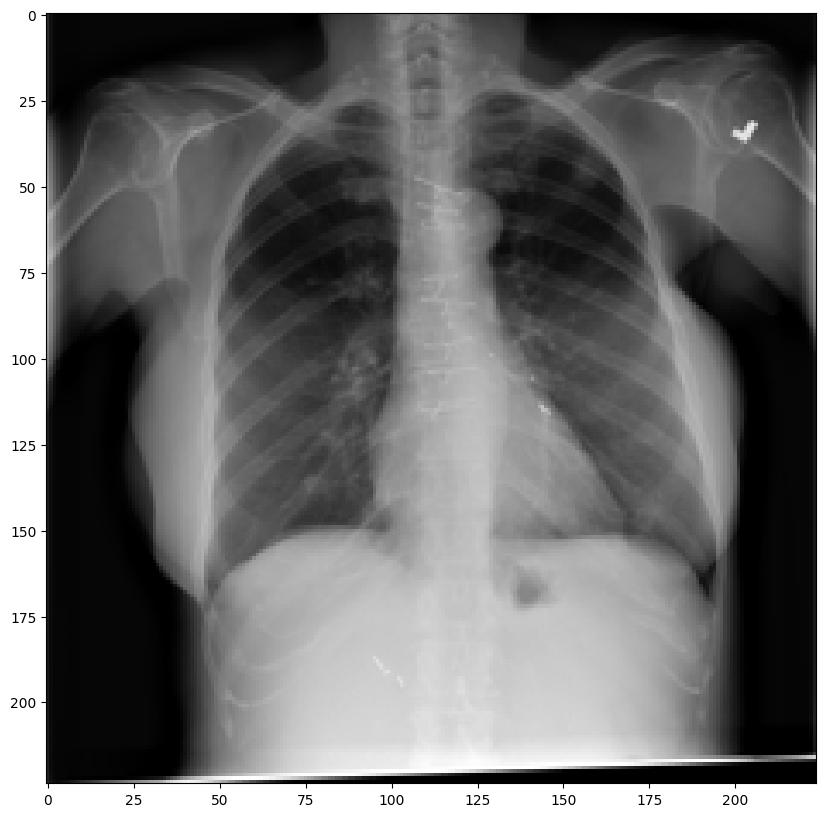

In [5]:
def displayImg(img):
    npImg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npImg,(1,2,0)))
    plt.show()

someImages = None
someLabels = None
someAges = None
i=0
for X,y,age in train_dl:
    someImages=X
    someLabels=y
    someAges = age
    break

for i in range(1,2):
    print(someAges[i])
    print(someLabels[i])
    displayImg(someImages[i])

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class TwoTaskResNet(nn.Module):
    def __init__(self,task_one_dimension,task_two_dimension):
        super().__init__()
        resnet = resnet18(num_classes=2)
        
        modules = list(resnet.children())[:-1]
        self.feature_extractor = nn.Sequential(*modules)

        self.task_one_layer = nn.Linear(resnet.fc.in_features,task_one_dimension)
        self.task_two_layer = nn.Linear(resnet.fc.in_features,task_two_dimension)

    def forward(self,x):
        features = self.feature_extractor(x)
        features = features.reshape(features.shape[0],features.shape[1])
        task_one_output = self.task_one_layer(features)
        task_two_output = self.task_two_layer(features)
        return task_one_output,task_two_output
    
model = TwoTaskResNet(task_one_dimension=2,task_two_dimension=1).to(device)
print(model.feature_extractor)
print(someImages[0:2].shape)
print(model.feature_extractor(someImages[0:2].to(device)).shape)
model.load_state_dict(torch.load('best.pkl'))
for param in model.feature_extractor.parameters():
    param.requires_grad = False
for param in model.task_one_layer.parameters():
    param.requires_grad = False

Using cuda device
Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)


In [7]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
#optimizer.load_state_dict(torch.load('optim_data.pkl'))
scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=200,eta_min=0.00001,last_epoch=-1)

In [8]:
def train(dataloader,model,loss_fn,optimizer):
    size = len(dataloader.dataset)
    train_loss = 0
    model.train() 
    for X,_,age in tqdm(dataloader):
        X,age = X.to(device), age.to(device)
        X = train_transform_gpu(X)
        # compute prediction
        _,predict = model(X)
        # compute loss
        loss = loss_fn(predict,age.reshape(len(age),1))
        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # record loss
        train_loss += loss.item() * len(age)
    return train_loss/size

def test(dataloader,model,loss_fn):
    size = len(dataloader.dataset)
    test_loss = 0
    model.eval()
    with torch.no_grad():
        for X,_,age in tqdm(dataloader):
            X,age = X.to(device),age.to(device)
            X = test_transform_gpu(X)
            _,predict = model(X)
            loss = loss_fn(predict,age.reshape(len(age),1))
            test_loss += loss.item()* len(age)
            
            
    return test_loss/size

In [ ]:
print('The training model is: ',model)
epochs = 100
for i in range(epochs):
    print('Epoch,',i)
    train_loss = train(train_dl,model,loss_fn,optimizer)
    test_loss= test(test_dl,model,loss_fn)
    print("train_loss:",train_loss)
    print("test_loss:",test_loss)
    scheduler.step()

The training model is:  TwoTaskResNet(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1

100%|██████████| 188/188 [00:07<00:00, 26.34it/s]


train_loss: 412.4488786688543
test_loss: 173.78997515869142
Epoch, 1


100%|██████████| 188/188 [00:06<00:00, 27.49it/s]


train_loss: 59.465674192611104
test_loss: 37.644439768473305
Epoch, 2


100%|██████████| 188/188 [00:06<00:00, 27.33it/s]


train_loss: 35.611833480418845
test_loss: 33.89757861328125
Epoch, 3


100%|██████████| 188/188 [00:06<00:00, 27.29it/s]


train_loss: 32.00940246492969
test_loss: 30.685570912679037
Epoch, 4


100%|██████████| 188/188 [00:06<00:00, 28.02it/s]


train_loss: 28.750402959946502
test_loss: 27.722669189453125
Epoch, 5


100%|██████████| 188/188 [00:06<00:00, 27.96it/s]


train_loss: 25.878722633971147
test_loss: 24.799902216593424
Epoch, 6


100%|██████████| 188/188 [00:06<00:00, 27.10it/s]


train_loss: 23.417815254481333
test_loss: 22.435547958374023
Epoch, 7


100%|██████████| 188/188 [00:07<00:00, 26.11it/s]


train_loss: 21.385178656061473
test_loss: 21.304930450439453
Epoch, 8


100%|██████████| 188/188 [00:07<00:00, 25.53it/s]


train_loss: 19.710816901312825
test_loss: 19.464165374755858
Epoch, 9


100%|██████████| 188/188 [00:07<00:00, 25.25it/s]


train_loss: 18.436711000396553
test_loss: 18.20547738647461
Epoch, 10


100%|██████████| 188/188 [00:07<00:00, 25.26it/s]


train_loss: 17.415906191096393
test_loss: 17.28589977010091
Epoch, 11


100%|██████████| 188/188 [00:06<00:00, 26.98it/s]


train_loss: 16.684307352957465
test_loss: 16.510585637410482
Epoch, 12


100%|██████████| 188/188 [00:07<00:00, 25.32it/s]


train_loss: 16.08436515758874
test_loss: 16.034648544311523
Epoch, 13


100%|██████████| 188/188 [00:06<00:00, 27.83it/s]


train_loss: 15.66402518622061
test_loss: 15.791543294270832
Epoch, 14


100%|██████████| 188/188 [00:06<00:00, 27.05it/s]


train_loss: 15.327574660246999
test_loss: 15.339427810668946
Epoch, 15


100%|██████████| 188/188 [00:07<00:00, 25.50it/s]


train_loss: 15.078409682158549
test_loss: 15.318588409423828
Epoch, 16


100%|██████████| 188/188 [00:07<00:00, 26.52it/s]


train_loss: 14.914490056264423
test_loss: 14.98773519897461
Epoch, 17


100%|██████████| 188/188 [00:07<00:00, 25.82it/s]


train_loss: 14.743733620279482
test_loss: 14.811097651163736
Epoch, 18


100%|██████████| 188/188 [00:06<00:00, 26.96it/s]


train_loss: 14.654620210887618
test_loss: 14.638242350260416
Epoch, 19


100%|██████████| 188/188 [00:06<00:00, 29.51it/s]


train_loss: 14.496810946360478
test_loss: 14.656168563842773
Epoch, 20


100%|██████████| 188/188 [00:06<00:00, 27.09it/s]


train_loss: 14.46389388772137
test_loss: 14.478257410685222
Epoch, 21


 33%|███▎      | 322/964 [00:11<00:19, 33.20it/s]